# 归一化的原因
不同规模的输入导致不同的权重更新和优化器的步骤向最小值的方向不均衡。这也使损失函数的形状不成比例。
在这种情况下，就需要使用较低的学习速率来避免过冲，这就意味着较慢的学习过程。
所以我们的解决方案是输入进行归一化，通过减去平均值(定心)并除以标准偏差来缩小特征。
此过程也称为“漂白”，处理后所有的值具有 0 均值和单位方差，这样可以提供更快的收敛和更稳定的训练。
这是一个很好的解决方案，那么为什么我们不规范化网络中每一层的激活呢？
下面我们先看一下针对于激活的归一化方法

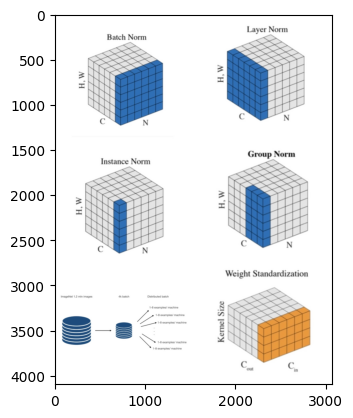

In [2]:
import cv2
from matplotlib import pyplot as plt

image = cv2.imread('./image/normalization.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

nn.BatchNorm2d：
    批归一化，对整个批次中的样本的特征进行归一化，对每个通道的特征图进行归一化，即对每个特征图的所有位置点进行归一化。适用于训练深度神经网络时，加速训练过程、提高模型的泛化能力。
nn.InstanceNorm2d：
    实例归一化，对每个样本（实例）的特征 (每个通道) 进行归一化，即对每个特征图的每个位置点进行归一化。适用于每个样本的特征分布不同的情况，如图像风格转换等任务。

# Batch Normalization
2015年，Batch Normalization: Accelerating Deep Network Training b y Reducing Internal Covariate Shift
 采用了这个想法来解决内部协变量偏移问题。 以前输入层分布由于权值的更新而不断变化。所以下面的层总是需要适应新的分布，它会导致收敛速度变慢和训练不稳定。
批量标准化提供了一种控制和优化每一层之后的分布的方法。 该过程与输入归一化相同，但我们添加了两个可学习的参数，γ 和 β。
- 优点：由于有固定的分布，所以可以提高学习率并加快收敛速度。 除了计算提升之外，BN 还可以作为一种正则化技术。 数据集统计数据的近似产生的噪声消除了对 Dropout 的需要。
- 缺点：这种估计仅适用于较大的批次。 当批次数量较少时，性能会急剧下降。如果我们传递了单个样本而不是批量的样本，网络必须使用预先计算的训练均值和方差，这可能会导致不同的结果。

In [2]:
import torch

def BatchNorm(x, gamma, beta, eps=1e-5):
# x: input shape [N, C, H, W]

    N, C, H, W = x.shape
    mean = torch.mean(input=x, dim=[0,2,3], keepdim=True)
    var = torch.var(input=x, dim=[0,2,3], keepdim=True)
    # mean, var shape : [1, C, 1, 1]

    x = (x - mean) / torch.sqrt(var + eps)

    return x * gamma + beta

/Users/rl/anaconda3/envs/torch107/bin/python3.7


# Layer Normalization
在2016年[4]中首次尝试减少对批大小的约束。提出这个方法的主要原因是无法找到将BN应用于递归神经网络，需要找到一个替代的方法。
在深度神经网络中，由于层数是固定的，因此很容易存储每个 BN 层的统计信息。 
然而在 RNN 中，输入和输出形状的长度不同。 因此，在这种情况下，最好使用单个时间步长（样本）而不是整个批次的统计信息进行标准化。

- 在这种方法中，batch(N) 中的每个示例都在 [C, H, W] 维度上进行了归一化。 与 BN 一样，它可以加速和稳定训练，并且不受批次的限制。

In [ ]:
def LayerNorm(x, gamma, beta, eps=1e-5):
# x: input shape [N, C, H, W]

    N, C, H, W = x.shape
    mean = torch.mean(input=x, dim=[1,2,3], keepdim=True)
    var = torch.var(input=x, dim=[1,2,3], keepdim=True)
    # mean, var shape: [N, 1, 1, 1]

    x = (x - mean) / torch.sqrt(var + eps)

    return x * gamma + beta

# Instance Normalization
在 2016 年的论文 《Instance Normalization: The Missing Ingredient for Fast Stylization》中。 这是另一种尝试减少对批处理的依赖以改善样式传输网络的结果。
跨批次和通道的标准化允许从图像中删除特定的对比度信息，这有助于泛化。
这种方法在 Pix2Pix 或 CycleGAN 等生成模型中广受欢迎，并成为著名的 StyleGAN2 中使用的自适应实例归一化的先驱。

In [ ]:
def InstanceNorm(x, gamma, beta, eps=1e-5):
# x: input shape [N, C, H, W]

    N, C, H, W = x.shape
    mean = torch.mean(input=x, dim=[2,3], keepdim=True)
    var = torch.var(input=x, dim=[2,3], keepdim=True)
    # mean, var shape: [N, C, 1, 1]

    x = (x - mean) / torch.sqrt(var + eps)

    return x * gamma + beta

# Group Normalization 
2018年被引入，它直接解决了 CNN 的 BN 限制。 主要针对的是分布式学习，其中批次被分成许多机器。 这些是在少数例子上训练的，比如 6-8，在某些情况下，甚至是 1-2。
GN 可以理解为Layer 和Instance的混合。 GN 将通道分成组并在它们之间进行标准化。 该方案使计算独立于批量大小。
GN 优于在小批量上训练的 BN，但无法击败大批量的结果，但是这是一个很好的起点。

In [ ]:
def GroupNorm(x, gamma, beta, G, eps=1e-5):
# x: input features with shape [N, C, H, W]
# G : number of groups

    N, C, H, W = x.shape
    x = torch.reshape(input=x, shape=[N, G, C // G, H, W])
    mean = torch.mean(input=x, dim=[2,3,4], keepdim=True)
    var = torch.var(input=x, dim=[2,3,4], keepdim=True)
    # mean, var shape : [N, G, 1, 1, 1]

    x = (x - mean) / torch.sqrt(var + eps)

    x = torch.reshape(input=x, shape=[N, C, H, W])

    return x * gamma + beta

# Weight Standardization
我们已经对输入和层输出进行了标准化，唯一剩下的就是权重。因为它们可以在没有任何控制的情况下变大，尤其是当我们无论如何都要标准化输出时。 
通过标准化权重，我们实现了更平滑的损失和更稳定的训练。
权重的标准化是Group Normalization的一个很好的辅助。 在仅使用一个样本的 BN（大批量）情况下，将这些方法结合起来会产生更好的结果。

In [ ]:
def WeightStand(w, eps=1e-5):
# w: input features shape [Cin, Cout, kernel_size, kernel_size]

    mean = torch.mean(input=w, dim=[0,2,3], keepdim=True)
    var = torch.var(input=w, dim=[0,2,3], keepdim=True)
    # mean, var shape : [1, Cout, 1, 1]

    w = (w - mean) / torch.sqrt(var + eps)

    return w
